# Installing packages

In [ ]:
!pip install kneed

In [ ]:
!pip install xgboost

In [ ]:
!pip install mlxtend --upgrade

     |████████████████████████████████| 1.4MB 7.5MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


# Importing packages

In [2]:
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVC
#from kneed import KneeLocator  
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import parallel_backend
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV              
from mlxtend.feature_selection import SequentialFeatureSelector as SFS 
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import classification_report, silhouette_score, confusion_matrix, mean_squared_error
# from sklearn import svm

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Defined functions and constants

In [3]:
# measures wall clock time in seconds
def calculate_elapsed_time(start, end):
  duration = end - start
  if duration >= 60:
    elapsed_time = duration/60
    print(f'This process took {elapsed_time:.2f} minutes')
  else:
    elapsed_time = duration
    print(f'This process took {elapsed_time:.2f} seconds')

In [4]:
SEED = 42

# Reading data

In [ ]:
from google.colab import files
uploaded_files = files.upload()

MessageError: ignored

In [5]:
data = pd.read_csv('tabela-s-trat.csv', sep = ';')

In [6]:
# show first five rows so we can have a look at the data
data.head()

,Sample_ID,Sample_Type,Receptor_Status_Patient,RB1,MDC1,ARAF,PREX2,SOX17,PPP4R2,MYC,AKT2,AKT3,AKT1,DAXX,PRKCI,MEF2B,DICER1,KNSTRN,NUP93,AR,PRKAR1A,PRKD1,MAPKAP1,PRDM14,GATA3,BCL10,GATA2,GATA1,GRIN2A,TERT,NTHL1,RAD21,NKX2-1,PLCG2,LYN,BARD1,JUN,CREBBP,H3F3B,H3F3C,...,AXIN1,AXIN2,ARID1A,ARID1B,TGFBR1,TGFBR2,ETV6,LATS1,GREM1,LATS2,ELF3,IRF4,RASA1,MYOD1,CBL,AURKB,AURKA,ERBB3,ERBB4,POLD1,GNA11,ERBB2,MAPK1,DROSHA,MYCL1,VHL,MAPK3,MUTYH,SPEN,TCF7L2,NEGR1,TSHR,ERCC3,ERCC4,RPS6KB2,HIST3H3,ERCC2,ERCC5,KRAS,TEK
0,P-0000004-T01-IM3,Primary,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,P-0000012-T02-IM3,Primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,P-0000015-T01-IM3,Metastasis,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,P-0000041-T01-IM3,Metastasis,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,P-0000057-T01-IM3,Primary,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
number_of_rows, number_of_columns = data.shape
print(f'The original dataset has {number_of_rows} rows and {number_of_columns} columns.')

The original dataset has 1907 rows and 426 columns.


# Looking at some descriptive statistics

In [8]:
data.describe(include = 'all')

,Sample_ID,Sample_Type,Receptor_Status_Patient,RB1,MDC1,ARAF,PREX2,SOX17,PPP4R2,MYC,AKT2,AKT3,AKT1,DAXX,PRKCI,MEF2B,DICER1,KNSTRN,NUP93,AR,PRKAR1A,PRKD1,MAPKAP1,PRDM14,GATA3,BCL10,GATA2,GATA1,GRIN2A,TERT,NTHL1,RAD21,NKX2-1,PLCG2,LYN,BARD1,JUN,CREBBP,H3F3B,H3F3C,...,AXIN1,AXIN2,ARID1A,ARID1B,TGFBR1,TGFBR2,ETV6,LATS1,GREM1,LATS2,ELF3,IRF4,RASA1,MYOD1,CBL,AURKB,AURKA,ERBB3,ERBB4,POLD1,GNA11,ERBB2,MAPK1,DROSHA,MYCL1,VHL,MAPK3,MUTYH,SPEN,TCF7L2,NEGR1,TSHR,ERCC3,ERCC4,RPS6KB2,HIST3H3,ERCC2,ERCC5,KRAS,TEK
count,1907,1907,1907.000000,1907,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.00000,1907.000000,1907.000000,1907.000000,1907.000000,1907,1907.000000,1907.000000,1907.000000,1907,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907,1907.000000,1907.000000,...,1907.000000,1907.000000,1907.000000,1907.000000,1907,1907.000000,1907,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907,1907.000000,1907.000000,1907.000000,1907,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907,1907.000000,1907,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000
unique,1907,2,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,...,NaN,NaN,NaN,NaN,2,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,P-0006090-T01-IM5,Metastasis,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,995,NaN,1885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1905,NaN,NaN,NaN,1885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1895,NaN,NaN,...,NaN,NaN,NaN,NaN,1905,NaN,1889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1903,NaN,NaN,NaN,1903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1906,NaN,1905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,-0.815417,NaN,0.004195,0.001049,0.011536,0.040902,-0.001049,0.170949,0.015732,0.018878,0.008390,0.004195,0.001049,0.011536,-0.003146,-0.001049,-0.001049,0.006293,0.06817,0.001049,0.002098,0.010488,0.032512,NaN,0.001049,0.002098,0.002098,NaN,0.001049,0.095438,0.009439,-0.003146,0.008390,-0.003146,-0.001049,NaN,0.009439,0.010488,...,0.010488,0.051390,-0.004195,-0.003146,NaN,-0.001049,NaN,0.003146,0.001049,-0.002098,0.016780,-0.002098,-0.001049,0.009439,NaN,-0.001049,0.072365,0.005244,NaN,0.009439,-0.001049,0.189827,0.009439,0.001049,0.007341,0.009439,0.007341,0.004195,NaN,-0.003146,NaN,-0.001049,-0.002098,0.009439,0.081804,0.016780,0.008390,0.000000,0.015732,-0.003146
std,NaN,NaN,0.579026,NaN,0.091526,0.079340,0.151499,0.283148,0.045799,0.559320,0.176726,0.204000,0.129301,0.112135,0.045799,0.151499,0.079284,0.045799,0.045799,0.129420,0.36299,0.045799,0.064752,0.144486,0.261146,NaN,0.045799,0.091598,0.112194,NaN,0.045799,0.426454,0.151644,0.079284,0.129301,0.079284,0.079340,NaN,0.151644,0.144486,...,0.144486,0.316529,0.091526,0.079284,NaN,0.045799,NaN,0.121163,0.079340,0.091598,0.182473,0.064752,0.102431,0.164903,NaN,0.045799,0.373586,0.102302,NaN,0.137108,0.045799,0.589913,0.137108,0.045799,0.120982,0.137108,0.120982,0.091526,NaN,0.102388,NaN,0.045799,0.064752,0.137108,0.401492,0.182473,0.129301,0.064786,0.176726,0.079284
min,NaN,NaN,-1.000000,NaN,0.000000,-2.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,-2.000000,0.000000,-2.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.00000,0.000000,0.000000,0.000000,-2.000000,NaN,0.000000,-2.000000,-2.000000,NaN,0.000000,0.000000,-2

In [ ]:
# looking at the descriptive statistics of each column
for col in data:
  print(col)
  print(data[col].describe())
  print("-"*30)

## Splitting data into X and y

In [9]:
X = data.drop(['Sample_ID','Sample_Type','Receptor_Status_Patient'],axis = 1)
y = data['Receptor_Status_Patient']

In [10]:
# looking at the types of data - seeing if they're numerical, categorical
X.dtypes

RB1        object
MDC1        int64
ARAF        int64
PREX2       int64
SOX17       int64
            ...  
HIST3H3     int64
ERCC2       int64
ERCC5       int64
KRAS        int64
TEK         int64
Length: 423, dtype: object

In [11]:
# grouping columns by dtype to be able to take a look at each kind of data type
X.columns.to_series().groupby(X.dtypes).groups

{int64: ['MDC1', 'ARAF', 'PREX2', 'SOX17', 'PPP4R2', 'MYC', 'AKT2', 'AKT3', 'AKT1', 'DAXX', 'PRKCI', 'MEF2B', 'DICER1', 'KNSTRN', 'NUP93', 'AR', 'PRKAR1A', 'PRKD1', 'MAPKAP1', 'PRDM14', 'GATA3', 'GATA2', 'GATA1', 'GRIN2A', 'NTHL1', 'RAD21', 'NKX2-1', 'PLCG2', 'LYN', 'BARD1', 'JUN', 'H3F3B', 'H3F3C', 'PLK2', 'H3F3A', 'BRAF', 'CYLD', 'FAM123B', 'REL', 'CDK12', 'EZH2', 'RET', 'SETD2', 'CDKN1A', 'CDKN1B', 'SETD8', 'CTCF', 'GLI1', 'BBC3', 'MED12', 'NUF2', 'CTLA4', 'IKBKE', 'JAK3', 'JAK1', 'DUSP4', 'UPF1', 'RRAS2', 'PAX5', 'RARA', 'PPARG', 'FH', 'GPS2', 'CENPA', 'EGFR', 'RECQL4', 'NRAS', 'EPCAM', 'NSD1', 'SPOP', 'PMS2', 'RICTOR', 'SF3B1', 'BRD4', 'CDKN2B', 'CDKN2C', 'CDKN2A', 'STAT3', 'RYBP', 'RFWD2', 'WT1', 'INHA', 'CRLF2', 'IRS1', 'IRS2', 'STK19', 'MSI2', 'FGF4', 'STK11', 'CYSLTR2', 'SESN3', 'PIM1', 'NBN', 'WHSC1L1', 'RNF43', 'MAP2K2', 'FBXW7', 'EIF1AX', 'TAP2', 'TAP1', ...], object: ['RB1', 'BCL10', 'TERT', 'CREBBP', 'AGO2', 'FAT1', 'JAK2', 'IFNGR1', 'NCOR1', 'SDHAF2', 'FGF3', 'PARK2', 'C

In [12]:
# distribution of targets on whole data
full_target_negatives = y.value_counts()[-1]
full_target_positives = y.value_counts()[1]

In [13]:
print(f'Sample of patients with triple negative breast cancer (full taget data): {full_target_positives/number_of_rows*100:.3f}% \
  \nSample of patients without triple negative breast cancer (full taget data): {full_target_negatives/number_of_rows*100:.3f}%')

Sample of patients with triple negative breast cancer (full taget data): 9.229%   
Sample of patients without triple negative breast cancer (full taget data): 90.771%


In [ ]:
np.unique(y)

In [ ]:
sns.scatterplot(data=X, legend=False);

## Cleaning data

In [14]:
X.replace(to_replace = ',', value = '.', regex = True, inplace = True)

In [15]:
# transforming object data to numeric since we only have numeric data
X = X.apply(pd.to_numeric)

In [16]:
X.columns.to_series().groupby(X.dtypes).groups

{int64: ['MDC1', 'ARAF', 'PREX2', 'SOX17', 'PPP4R2', 'MYC', 'AKT2', 'AKT3', 'AKT1', 'DAXX', 'PRKCI', 'MEF2B', 'DICER1', 'KNSTRN', 'NUP93', 'AR', 'PRKAR1A', 'PRKD1', 'MAPKAP1', 'PRDM14', 'GATA3', 'GATA2', 'GATA1', 'GRIN2A', 'NTHL1', 'RAD21', 'NKX2-1', 'PLCG2', 'LYN', 'BARD1', 'JUN', 'H3F3B', 'H3F3C', 'PLK2', 'H3F3A', 'BRAF', 'CYLD', 'FAM123B', 'REL', 'CDK12', 'EZH2', 'RET', 'SETD2', 'CDKN1A', 'CDKN1B', 'SETD8', 'CTCF', 'GLI1', 'BBC3', 'MED12', 'NUF2', 'CTLA4', 'IKBKE', 'JAK3', 'JAK1', 'DUSP4', 'UPF1', 'RRAS2', 'PAX5', 'RARA', 'PPARG', 'FH', 'GPS2', 'CENPA', 'EGFR', 'RECQL4', 'NRAS', 'EPCAM', 'NSD1', 'SPOP', 'PMS2', 'RICTOR', 'SF3B1', 'BRD4', 'CDKN2B', 'CDKN2C', 'CDKN2A', 'STAT3', 'RYBP', 'RFWD2', 'WT1', 'INHA', 'CRLF2', 'IRS1', 'IRS2', 'STK19', 'MSI2', 'FGF4', 'STK11', 'CYSLTR2', 'SESN3', 'PIM1', 'NBN', 'WHSC1L1', 'RNF43', 'MAP2K2', 'FBXW7', 'EIF1AX', 'TAP2', 'TAP1', ...], float64: ['RB1', 'BCL10', 'TERT', 'CREBBP', 'AGO2', 'FAT1', 'JAK2', 'IFNGR1', 'NCOR1', 'SDHAF2', 'FGF3', 'PARK2', '

In [17]:
X.head()

,RB1,MDC1,ARAF,PREX2,SOX17,PPP4R2,MYC,AKT2,AKT3,AKT1,DAXX,PRKCI,MEF2B,DICER1,KNSTRN,NUP93,AR,PRKAR1A,PRKD1,MAPKAP1,PRDM14,GATA3,BCL10,GATA2,GATA1,GRIN2A,TERT,NTHL1,RAD21,NKX2-1,PLCG2,LYN,BARD1,JUN,CREBBP,H3F3B,H3F3C,PLK2,H3F3A,BRAF,...,AXIN1,AXIN2,ARID1A,ARID1B,TGFBR1,TGFBR2,ETV6,LATS1,GREM1,LATS2,ELF3,IRF4,RASA1,MYOD1,CBL,AURKB,AURKA,ERBB3,ERBB4,POLD1,GNA11,ERBB2,MAPK1,DROSHA,MYCL1,VHL,MAPK3,MUTYH,SPEN,TCF7L2,NEGR1,TSHR,ERCC3,ERCC4,RPS6KB2,HIST3H3,ERCC2,ERCC5,KRAS,TEK
0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0
1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0
4,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0


In [18]:
X.dtypes

RB1        float64
MDC1         int64
ARAF         int64
PREX2        int64
SOX17        int64
            ...   
HIST3H3      int64
ERCC2        int64
ERCC5        int64
KRAS         int64
TEK          int64
Length: 423, dtype: object

In [ ]:
number_of_rows, number_of_columns = X.shape
print(f'The cleaned features data has {number_of_rows} rows and {number_of_columns} columns.')

The cleaned features data has 1907 rows and 423 columns.


In [ ]:
sns.histplot(data=X, legend=False);

## Splitting data into train and test

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    #test_size = 0.25, 
                                                    #random_state = SEED)

## Using standard scaler to scale data

In [19]:
# standard_scaler = StandardScaler(with_mean=False) # with mean false to maintain sparsity
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

In [21]:
X_scaled = pd.DataFrame(X_scaled, 
                              index = X.index, 
                              columns = X.columns)

In [22]:
X_scaled.head()

,RB1,MDC1,ARAF,PREX2,SOX17,PPP4R2,MYC,AKT2,AKT3,AKT1,DAXX,PRKCI,MEF2B,DICER1,KNSTRN,NUP93,AR,PRKAR1A,PRKD1,MAPKAP1,PRDM14,GATA3,BCL10,GATA2,GATA1,GRIN2A,TERT,NTHL1,RAD21,NKX2-1,PLCG2,LYN,BARD1,JUN,CREBBP,H3F3B,H3F3C,PLK2,H3F3A,BRAF,...,AXIN1,AXIN2,ARID1A,ARID1B,TGFBR1,TGFBR2,ETV6,LATS1,GREM1,LATS2,ELF3,IRF4,RASA1,MYOD1,CBL,AURKB,AURKA,ERBB3,ERBB4,POLD1,GNA11,ERBB2,MAPK1,DROSHA,MYCL1,VHL,MAPK3,MUTYH,SPEN,TCF7L2,NEGR1,TSHR,ERCC3,ERCC4,RPS6KB2,HIST3H3,ERCC2,ERCC5,KRAS,TEK
0,0.106935,-0.045847,-0.013222,-0.076169,-0.144492,0.022905,-0.305718,-0.08904,-0.092562,-0.064906,-0.037421,-0.022905,-0.076169,0.039694,0.022905,0.022905,-0.048634,-0.18785,-0.022905,-0.032402,-0.072605,-0.124529,-0.00458,-0.022905,-0.022905,-0.018701,-0.092566,-0.022905,-0.223853,-0.06226,0.039694,-0.064906,0.039694,0.013222,-0.033291,-0.06226,-0.072605,0.014484,-0.06625,-0.045847,...,-0.072605,-0.162396,0.045847,0.039694,0.032402,0.022905,-0.067088,-0.025974,-0.013222,0.022905,-0.091984,0.032402,0.010241,-0.057254,0.045544,0.022905,-0.193754,-0.051272,0.045544,-0.068861,0.022905,-0.321873,-0.068861,-0.022905,-0.060698,-0.068861,-0.060698,-0.045847,0.022905,0.030737,-0.00458,0.022905,0.032402,-0.068861,-0.203803,-0.091984,-0.064906,0.0,-0.08904,0.039694
1,0.106935,-0.045847,-0.013222,-0.076169,-0.144492,0.022905,-0.305718,-0.08904,-0.092562,-0.064906,-0.037421,-0.022905,-0.076169,0.039694,0.022905,0.022905,-0.048634,-0.18785,-0.022905,-0.032402,-0.072605,-0.124529,-0.00458,-0.022905,-0.022905,-0.018701,-0.092566,-0.022905,-0.223853,-0.06226,0.039694,-0.064906,0.039694,0.013222,-0.033291,-0.06226,-0.072605,0.014484,-0.06625,-0.045847,...,-0.072605,-0.162396,0.045847,0.039694,0.032402,0.022905,-0.067088,-0.025974,-0.013222,0.022905,-0.091984,0.032402,0.010241,-0.057254,0.045544,0.022905,-0.193754,-0.051272,0.045544,-0.068861,0.022905,-0.321873,-0.068861,-0.022905,-0.060698,-0.068861,-0.060698,-0.045847,0.022905,0.030737,-0.00458,0.022905,0.032402,-0.068861,-0.203803,-0.091984,-0.064906,0.0,-0.08904,0.039694
2,0.106935,-0.045847,-0.013222,-0.076169,-0.144492,0.022905,-0.305718,-0.08904,-0.092562,-0.064906,-0.037421,-0.022905,-0.076169,0.039694,0.022905,0.022905,-0.048634,-0.18785,-0.022905,-0.032402,-0.072605,-0.124529,-0.00458,-0.022905,-0.022905,-0.018701,-0.092566,-0.022905,-0.223853,-0.06226,0.039694,-0.064906,0.039694,0.013222,-0.033291,-0.06226,-0.072605,0.014484,-0.06625,-0.045847,...,-0.072605,-0.162396,0.045847,0.039694,0.032402,0.022905,-0.067088,-0.025974,-0.013222,0.022905,-0.091984,0.032402,0.010241,-0.057254,0.045544,0.022905,-0.193754,-0.051272,0.045544,-0.068861,0.022905,-0.321873,-0.068861,-0.022905,-0.060698,-0.068861,-0.060698,-0.045847,0.022905,0.030737,-0.00458,0.022905,0.032402,-0.068861,-0.203803,-0.091984,-0.064906,0.0,-0.08904,0.039694
3,0.106935,-0.045847,-0.013222,-0.076169,-0.144492,0.022905,-0.305718,-0.08904,-0.092562,-0.064906,-0.037421,-0.022905,-0.076169,0.039694,0.022905,0.022905,-0.048634,-0.18785,-0.022905,-0.032402,-0.072605,-0.124529,-0.00458,-0.022905,-0.022905,-0.018701,-0.092566,-0.022905,-0.223853,-0.06226,0.039694,-0.064906,0.039694,0.013222,-0.033291,-0.06226,-0.072605,0.014484,-0.06625,-0.045847,...,-0.072605,-0.162396,0.045847,0.039694,0.032402,0.022905,-0.067088,-0.025974,-0.013222,0.022905,-0.091984,0.032402,0.010241,-0.057254,0.045544,0.022905,-0.193754,-0.051272,0.045544,-0.068861,0.022905,-0.321873,-0.068861,-0.022905,-0.060698,-0.068861,-0.060698,-0.045847,0.022905,0.030737,-0.00458,0.022905,0.032402,-0.068861,-0.203803,-0.091984,-0.064906,0.0,-0.08904,0.039694
4,0.106935,-0.045847,-0.013222,-0.076169,-0.144492,0.022905,-0.305718,-0.08904,-0.092562,-0.064906,-0.037421,-0.022905,-0.076169,0.039694,0.022905,0.022905,-0.048634,-0.18785,-0.022905,-0.032402,-0.072605,-0.124529,-0.00458,-0.022905,-0.022905,-0.018701,-0.092566,-0.022905,-0.223853,-0.06226,0.039694,-0.064906,0.039694,0.013222,-0.033291,-0.06226,-0.072605,0.014484,-0.06625,-0.045847,...,-0.072605,-0.162396,0.045847,0.039694,0.032402,0.022905,-0.067088,-

In [ ]:
sns.scatterplot(data=X_scaled, legend=False);

# Clustering scaled data

## Clustering standard scaled data

### Choosing number of KMeans ks with SSE (sum of squared errors)

https://realpython.com/k-means-clustering-python/ na parte do "Choosing the apropriate number of clusters"
Demora um tempinho pra rodar

`Clica em Runtime -> Change Runtime Type -> escolhe GPU (o note vai reestartar) e veja a célula abaixo rodar em aprox 20, 30 min -- com 423 ks -- o que eu suspeito fortemente que a gente vai conseguir mudar`

In [ ]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": SEED,
 }

In [ ]:
# A list holds the SSE values for each k
sse = []

start_sse = time.clock()

with parallel_backend('multiprocessing'):
  for k in range(1, number_of_columns+1):
      kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
      kmeans.fit(X_train_scaled)
      sse.append(kmeans.inertia_)

end_sse = time.clock()   

In [ ]:
calculate_elapsed_time(start_sse, end_sse)

Pesquisar o convergence warning que ta berrando aqui

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: ConvergenceWarning: Number of distinct clusters (372) found smaller than n_clusters (390). Possibly due to duplicate points in X.
  del sys.path[0]

In [ ]:
kl = KneeLocator(range(1, number_of_columns+1), sse, curve="convex", direction="decreasing")
number_of_clusters = kl.elbow
print(number_of_clusters)

In [ ]:
# aqui para não ter que re - rodar tudo do SSE
number_of_clusters = 37

In [ ]:
# se testar para 423 ks se confirmar, teremos que alterar para 0, 423 -- repare abaixo que vai até 422
print(list(range(1, 423)))

In [ ]:
# aqui tem cada centroide encontrado?
len(sse)

### Plotting the elbow curve

In [ ]:
plot = sns.lineplot(x=range(1, number_of_columns+1), y=sse)
plot.set(xlabel='Number of clusters', ylabel='SSE', title='Elbow curve');

### Running silhouette score

In [ ]:
predicted_labels = kmeans.predict(X = X_train_scaled)

In [ ]:
for cluster_number in range(2, number_of_columns):
  ss = silhouette_score(X_train_scaled, labels=predicted_labels, random_state=SEED)
  print(f'Number of clusters: {cluster_number} score: {ss:.3f}')

All clusters had the same score: 0.370

## Selecting features with Sequential Feature Selector (SFS)
> Reminder: grab a cup of coffee/tea while running SFS

### SFS with SVM Classifier

https://towardsdatascience.com/feature-selection-for-machine-learning-in-python-wrapper-methods-2b5e27d2db31

In [ ]:
#Define Sequential Forward Selection (sfs)

svc_clf = SVC(random_state = SEED)

sfs = SFS(svc_clf,
          k_features = number_of_clusters,
          forward=True,
          floating=False,
          verbose=2,
          scoring = 'f1',
          cv = 10)

In [ ]:
xgbc_clf = xgb.XGBClassifier(use_label_encoder=False, random_state=SEED)

sfs = SFS(xgbc_clf,
          k_features = 42,
          forward=True,
          floating=False,
          verbose=2,
          scoring = 'f1',
          cv = 5)


In [ ]:
#Use SFS to select the features 
start_sfs = time.clock()

with parallel_backend('multiprocessing'):
  sfs.fit(X_scaled, y)

end_sfs = time.clock()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 423 out of 423 | elapsed:   41.8s finished

[2020-12-17 18:06:38] Features: 1/42 -- score: 0.08425551057130005[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:   54.8s finished

[2020-12-17 18:07:33] Features: 2/42 -- score: 0.13344150905126514[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 421 out of 421 | elapsed:  1.1min finished

[2020-12-17 18:08:37] Features: 3/42 -- score: 0.16986688108639325[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

In [ ]:
calculate_elapsed_time(start_sfs, end_sfs)

This process took 113.86 minutes


In [ ]:
fig_sfs = plot_sfs(sfs.get_metric_dict(), kind='std_dev')#, figsize=(10, 6))
plt.ylim([0.1, 1])
plt.title('Sequential forward selection with SVM and standard deviation')
plt.grid()
plt.show()

## SFS results

### SFS with SVM

In [ ]:
#Create a dataframe for the SFS results 
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()

In [ ]:
# displays full row dataframe information
pd.set_option('display.max_colwidth', None)

In [ ]:
df_SFS_results

,feature_idx,cv_scores,avg_score,feature_names
1,"(327,)","[0.10256410256410256, 0.0, 0.10526315789473684, 0.05555555555555556, 0.15789473684210528]",0.0842555,"(CCND2,)"
2,"(313, 327)","[0.09756097560975609, 0.10256410256410256, 0.15384615384615383, 0.1081081081081081, 0.20512820512820512]",0.133442,"(MAP3K1, CCND2)"
3,"(313, 326, 327)","[0.09523809523809522, 0.19512195121951217, 0.19999999999999998, 0.15384615384615383, 0.20512820512820512]",0.169867,"(MAP3K1, CCND3, CCND2)"
4,"(109, 313, 326, 327)","[0.09523809523809522, 0.19512195121951217, 0.20512820512820512, 0.15384615384615383, 0.20512820512820512]",0.170893,"(MAP2K4, MAP3K1, CCND3, CCND2)"
5,"(92, 109, 313, 326, 327)","[0.13043478260869562, 0.19512195121951217, 0.20512820512820512, 0.15384615384615383, 0.20512820512820512]",0.177932,"(CRLF2, MAP2K4, MAP3K1, CCND3, CCND2)"
6,"(92, 109, 313, 322, 326, 327)","[0.09523809523809522, 0.2380952380952381, 0.20512820512820512, 0.15384615384615383, 0.20512820512820512]",0.179487,"(CRLF2, MAP2K4, MAP3K1, MPL, CCND3, CCND2)"
7,"(92, 109, 313, 322, 326, 327, 421)","[0.13043478260869562, 0.2380952380952381, 0.19999999999999998, 0.15384615384615383, 0.20512820512820512]",0.185501,"(CRLF2, MAP2K4, MAP3K1, MPL, CCND3, CCND2, KRAS)"
8,"(1, 92, 109, 313, 322, 326, 327, 421)","[0.13043478260869562, 0.2380952380952381, 0.19999999999999998, 0.15384615384615383, 0.20512820512820512]",0.185501,"(MDC1, CRLF2, MAP2K4, MAP3K1, MPL, CCND3, CCND2, KRAS)"
9,"(1, 2, 92, 109, 313, 322, 326, 327, 421)","[0.13043478260869562, 0.2380952380952381, 0.19999999999999998, 0.15384615384615383, 0.20512820512820512]",0.185501,"(MDC1, ARAF, CRLF2, MAP2K4, MAP3K1, MPL, CCND3, CCND2, KRAS)"
10,"(1, 2, 3, 92, 109, 313, 322, 326, 327, 421)","[0.13043478260869562, 0.2380952380952381, 0.19999999999999998, 0.15384615384615383, 0.20512820512820512]",0.185501,"(MDC1, ARAF, PREX2, CRLF2, MAP2K4, MAP3K1, MPL, CCND3, CCND2, KRAS)"


42: (MDC1, ARAF, PREX2, PPP4R2, AKT1, DAXX, PRKCI, DICER1, KNSTRN, NUP93, AR, PRKD1, MAPKAP1, PRDM14, BCL10, GATA2, GATA1, GRIN2A, TERT, NTHL1, NKX2-1, PLCG2, LYN, BARD1, JUN, CREBBP, H3F3B, BRAF, CYLD, FAM123B, REL, FAT1, EZH2, RET, CRLF2, MAP2K4, PIK3CA, MAP3K1, MPL, CCND3, CCND2, KRAS)


7: (CRLF2, MAP2K4, MAP3K1, MPL, CCND3, CCND2, KRAS) 

-- podemos usar 16 ao inves de 31 features que dá na mesma para o score médio e cv scores, certo?

In [ ]:
#sfs.subsets_[7]

In [23]:
sfs_feature_names_list = ['MDC1', 'ARAF', 'PREX2', 'PPP4R2', 'AKT1', 'DAXX', 'PRKCI', 'DICER1', 'KNSTRN', 
                          'NUP93', 'AR', 'PRKD1', 'MAPKAP1', 'PRDM14', 'BCL10', 'GATA2', 'GATA1', 'GRIN2A', 'TERT',
                          'CRLF2', 'MAP2K4', 'PIK3CA', 'MAP3K1', 'MPL', 'CCND3', 'CCND2', 'KRAS']

In [24]:
len(sfs_feature_names_list)

27

## Selecting the reduced columns

### Reduced columns for SFS with XgBoost

In [25]:
# feature_names = list(sfs.subsets_[number_of_clusters]['feature_names'])
feature_names = sfs_feature_names_list

In [26]:
X_selected = X_scaled[feature_names]

In [27]:
X_selected.head()

,MDC1,ARAF,PREX2,PPP4R2,AKT1,DAXX,PRKCI,DICER1,KNSTRN,NUP93,AR,PRKD1,MAPKAP1,PRDM14,BCL10,GATA2,GATA1,GRIN2A,TERT,CRLF2,MAP2K4,PIK3CA,MAP3K1,MPL,CCND3,CCND2,KRAS
0,-0.045847,-0.013222,-0.076169,0.022905,-0.064906,-0.037421,-0.022905,0.039694,0.022905,0.022905,-0.048634,-0.022905,-0.032402,-0.072605,-0.00458,-0.022905,-0.022905,-0.018701,-0.092566,0.06226,0.14159,-0.100317,0.053508,-0.082848,-0.048634,-0.034369,-0.08904
1,-0.045847,-0.013222,-0.076169,0.022905,-0.064906,-0.037421,-0.022905,0.039694,0.022905,0.022905,-0.048634,-0.022905,-0.032402,-0.072605,-0.00458,-0.022905,-0.022905,-0.018701,-0.092566,0.06226,0.14159,-0.100317,0.053508,-0.082848,-0.048634,-0.034369,-0.08904
2,-0.045847,-0.013222,-0.076169,0.022905,-0.064906,-0.037421,-0.022905,0.039694,0.022905,0.022905,-0.048634,-0.022905,-0.032402,-0.072605,-0.00458,-0.022905,-0.022905,-0.018701,-0.092566,0.06226,0.14159,-0.100317,0.053508,-0.082848,-0.048634,-0.034369,-0.08904
3,-0.045847,-0.013222,-0.076169,0.022905,-0.064906,-0.037421,-0.022905,0.039694,0.022905,0.022905,-0.048634,-0.022905,-0.032402,-0.072605,-0.00458,-0.022905,-0.022905,-0.018701,-0.092566,0.06226,0.14159,-0.100317,0.053508,-0.082848,-0.048634,-0.034369,-0.08904
4,-0.045847,-0.013222,-0.076169,0.022905,-0.064906,-0.037421,-0.022905,0.039694,0.022905,0.022905,-0.048634,-0.022905,-0.032402,-0.072605,-0.00458,-0.022905,-0.022905,-0.018701,-0.092566,0.06226,0.14159,-0.100317,0.053508,-0.082848,-0.048634,-0.034369,-0.08904


# Running the models

## GridSearchCV with XGBoost

https://xgboost.readthedocs.io/en/latest/parameter.html

https://www.kaggle.com/phunter/xgboost-with-gridsearchcv

In [28]:
xgbc = xgb.XGBClassifier(use_label_encoder=False)

params_xgbc = {'objective': ['binary:logistic', 'binary:logitraw', 'binary:hinge'],
              'random_state': [SEED],
              'colsample_bytree': [0.001, 0.01, 0.05, 0.1, 0.5, 1],
              'learning_rate': [0.01, 0.05, 0.1, 0.5],
              'max_depth': [2, 4, 6],
              'alpha': [2, 4, 6, 8, 10]}

In [29]:
gs_xgbc = GridSearchCV(xgbc, 
                      param_grid = params_xgbc,  
                      scoring = ['roc_auc', 'f1', 'accuracy'],
                      refit = 'f1',
                      verbose = 3,
                      cv = 5)

In [30]:
start_gs_xgbc = time.clock()

gs_xgbc.fit(X_selected, y)

end_gs_xgbc = time.clock()

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
[CV] alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42, accuracy=0.908, f1=0.000, roc_auc=0.526, total=   1.0s
[CV] alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42 
[CV]  alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42, accuracy=0.906, f1=0.000, roc_auc=0.583, total=   0.0s
[CV] alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42 
[CV]  alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42, accuracy=0.908, f1=0.000, roc_auc=0.563, total=   0.0s
[CV] alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42 
[CV]  alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42, accuracy=0.908, f1=0.000, 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV] alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42 
[CV]  alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42, accuracy=0.908, f1=0.000, roc_auc=0.526, total=   0.1s
[CV] alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42 
[CV]  alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42, accuracy=0.906, f1=0.000, roc_auc=0.592, total=   0.1s
[CV] alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42 
[CV]  alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42, accuracy=0.908, f1=0.000, roc_auc=0.558, total=   0.1s
[CV] alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_

[Parallel(n_jobs=1)]: Done 5400 out of 5400 | elapsed:  5.8min finished


In [31]:
calculate_elapsed_time(start_gs_xgbc, end_gs_xgbc)

This process took 5.81 minutes


In [32]:
xgbc_gs = gs_xgbc.best_estimator_

In [33]:
xgbc_gs

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:hinge', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [34]:
y_pred_xgbc = xgbc_gs.predict(X_selected)

### Confusion matrix and classification report

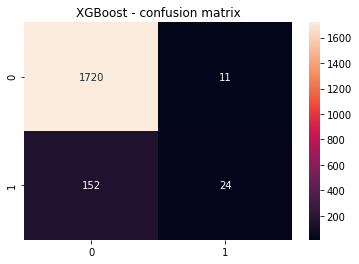

In [35]:
cm_xgbc = confusion_matrix(y, y_pred_xgbc)

sns.heatmap(cm_xgbc, annot=True, fmt='d').set_title('XGBoost - confusion matrix');

In [36]:
print('XGBoost - classification report\n\n', classification_report(y, y_pred_xgbc))

XGBoost - classification report

               precision    recall  f1-score   support

          -1       0.92      0.99      0.95      1731
           1       0.69      0.14      0.23       176

    accuracy                           0.91      1907
   macro avg       0.80      0.57      0.59      1907
weighted avg       0.90      0.91      0.89      1907



In [37]:
xgbc_gs.fit(X_selected, y)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:hinge', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [ ]:
xgbc_gs.score(X_selected, y)

0.9119035133717881

In [ ]:
xgbc_gs.score(X_test_selected, y_test)

0.9056603773584906

In [ ]:
pickle.dump(xgbc_gs, open('xgb_model.pkl', 'wb'))

# Installing packages

In [ ]:
!pip install kneed

In [ ]:
!pip install xgboost

In [ ]:
!pip install mlxtend --upgrade

     |████████████████████████████████| 1.4MB 7.5MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


# Importing packages

In [1]:
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVC
#from kneed import KneeLocator  
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import parallel_backend
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV              
from mlxtend.feature_selection import SequentialFeatureSelector as SFS 
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import classification_report, silhouette_score, confusion_matrix, mean_squared_error
# from sklearn import svm

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Defined functions and constants

In [2]:
# measures wall clock time in seconds
def calculate_elapsed_time(start, end):
  duration = end - start
  if duration >= 60:
    elapsed_time = duration/60
    print(f'This process took {elapsed_time:.2f} minutes')
  else:
    elapsed_time = duration
    print(f'This process took {elapsed_time:.2f} seconds')

In [3]:
SEED = 42

# Reading data

In [ ]:
from google.colab import files
uploaded_files = files.upload()

MessageError: ignored

In [5]:
data = pd.read_csv('tabela-trat.csv', sep = ';')

In [6]:
# show first five rows so we can have a look at the data
data.head()

,Sample_ID,Sample_Type,Receptor_Status_Patient,RB1,MDC1,ARAF,PREX1,SOX17,PPP4R1,MYC,AKT1,AKT3,AKT1.1,DAXX,PRKCI,MEF1B,DICER1,KNSTRN,NUP93,AR,PRKAR1A,PRKD1,MAPKAP1,PRDM14,GATA3,BCL10,GATA1,GATA1.1,GRIN1A,TERT,NTHL1,RAD11,NKX11,PLCG1,LYN,BARD1,JUN,CREBBP,H3F3B,H3F3C,...,AXIN1,AXIN1.1,ARID1A,ARID1B,TGFBR1,TGFBR1.1,ETV6,LATS1,GREM1,LATS1.1,ELF3,IRF4,RASA1,MYOD1,CBL,AURKB,AURKA,ERBB3,ERBB4,POLD1,GNA11,ERBB1,MAPK1,DROSHA,MYCL1,VHL,MAPK3,MUTYH,SPEN,TCF7L1,NEGR1,TSHR,ERCC3,ERCC4,RPS6KB1,HIST3H3,ERCC1,ERCC5,KRAS,TEK
0,P-0000004-T01-IM3,Primary,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,P-0000012-T02-IM3,Primary,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,P-0000015-T01-IM3,Metastasis,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,P-0000041-T01-IM3,Metastasis,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,P-0000057-T01-IM3,Primary,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
number_of_rows, number_of_columns = data.shape
print(f'The original dataset has {number_of_rows} rows and {number_of_columns} columns.')

The original dataset has 1907 rows and 426 columns.


# Looking at some descriptive statistics

In [ ]:
data.describe(include = 'all')

,Sample_ID,Sample_Type,Receptor_Status_Patient,RB1,MDC1,ARAF,PREX2,SOX17,PPP4R2,MYC,AKT2,AKT3,AKT1,DAXX,PRKCI,MEF2B,DICER1,KNSTRN,NUP93,AR,PRKAR1A,PRKD1,MAPKAP1,PRDM14,GATA3,BCL10,GATA2,GATA1,GRIN2A,TERT,NTHL1,RAD21,NKX2.1,PLCG2,LYN,BARD1,JUN,CREBBP,H3F3B,H3F3C,...,AXIN1,AXIN2,ARID1A,ARID1B,TGFBR1,TGFBR2,ETV6,LATS1,GREM1,LATS2,ELF3,IRF4,RASA1,MYOD1,CBL,AURKB,AURKA,ERBB3,ERBB4,POLD1,GNA11,ERBB2,MAPK1,DROSHA,MYCL1,VHL,MAPK3,MUTYH,SPEN,TCF7L2,NEGR1,TSHR,ERCC3,ERCC4,RPS6KB2,HIST3H3,ERCC2,ERCC5,KRAS,TEK
count,1907,1907,1907.000000,1885.0,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1905.0,1907.000000,1907.000000,1907.000000,1885.0,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1895.0,1907.000000,1907.000000,...,1907.000000,1907.000000,1907.000000,1907.000000,1905.0,1907.000000,1889.0,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1903.0,1907.000000,1907.000000,1907.000000,1903.0,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1906.0,1907.000000,1905.0,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000
unique,1907,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,P-0006091-T01-IM5,Metastasis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,-0.815417,0.0,0.002098,0.001573,0.005768,0.020451,0.000524,0.085475,0.007866,0.010488,0.004195,0.003146,0.000524,0.005768,0.001573,0.000524,0.000524,0.004195,0.034085,0.000524,0.001049,0.005244,0.017305,0.0,0.000524,0.002098,0.003146,0.0,0.000524,0.047719,0.005768,0.001573,0.004195,0.001573,0.001573,0.0,0.005768,0.005244,...,0.005244,0.025695,0.002098,0.001573,0.0,0.000524,0.0,0.003671,0.001573,0.002098,0.008390,0.001049,0.002622,0.006817,0.0,0.000524,0.036182,0.002622,0.0,0.004719,0.000524,0.095962,0.004719,0.000524,0.003671,0.004719,0.003671,0.002098,0.0,0.002622,0.0,0.000524,0.001049,0.004719,0.041951,0.008390,0.004195,0.001049,0.007866,0.001573
std,NaN,NaN,0.579026,0.0,0.045763,0.039642,0.075749,0.141574,0.022899,0.279660,0.088363,0.101898,0.064650,0.056018,0.022899,0.075749,0.039642,0.022899,0.022899,0.064650,0.181495,0.022899,0.032376,0.072243,0.130438,0.0,0.022899,0.045763,0.056018,0.0,0.022899,0.213227,0.075749,0.039642,0.064650,0.039642,0.039642,0.0,0.075749,0.072243,...,0.072243,0.158265,0.045763,0.039642,0.0,0.022899,0.0,0.060491,0.039642,0.045763,0.091237,0.032376,0.051151,0.082305,0.0,0.022899,0.186793,0.051151,0.0,0.068554,0.022899,0.294617,0.068554,0.022899,0.060491,0.068554,0.060491,0.045763,0.0,0.051151,0.0,0.022899,0.032376,0.068554,0.200529,0.091237,0.064650,0.032376,0.088363,0.039642
min,NaN,NaN,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,

In [ ]:
# looking at the descriptive statistics of each column
for col in data:
  print(col)
  print(data[col].describe())
  print("-"*30)

## Splitting data into X and y

In [8]:
X = data.drop(['Sample_ID','Sample_Type','Receptor_Status_Patient'],axis = 1)
y = data['Receptor_Status_Patient']

In [9]:
# looking at the types of data - seeing if they're numerical, categorical
X.dtypes

RB1        int64
MDC1       int64
ARAF       int64
PREX1      int64
SOX17      int64
           ...  
HIST3H3    int64
ERCC1      int64
ERCC5      int64
KRAS       int64
TEK        int64
Length: 423, dtype: object

In [10]:
# grouping columns by dtype to be able to take a look at each kind of data type
X.columns.to_series().groupby(X.dtypes).groups

{int64: ['RB1', 'MDC1', 'ARAF', 'PREX1', 'SOX17', 'PPP4R1', 'MYC', 'AKT1', 'AKT3', 'AKT1.1', 'DAXX', 'PRKCI', 'MEF1B', 'DICER1', 'KNSTRN', 'NUP93', 'AR', 'PRKAR1A', 'PRKD1', 'MAPKAP1', 'PRDM14', 'GATA3', 'BCL10', 'GATA1', 'GATA1.1', 'GRIN1A', 'TERT', 'NTHL1', 'RAD11', 'NKX11', 'PLCG1', 'LYN', 'BARD1', 'JUN', 'CREBBP', 'H3F3B', 'H3F3C', 'PLK1', 'H3F3A', 'BRAF', 'CYLD', 'FAM113B', '01/08/1001', 'REL', 'FAT1', 'CDK11', 'EZH1', 'RET', 'SETD1', 'CDKN1A', 'CDKN1B', 'SETD8', 'CTCF', 'GLI1', 'BBC3', 'MED11', 'NUF1', 'CTLA4', 'JAK1', 'IKBKE', 'JAK3', 'JAK1.1', 'DUSP4', 'UPF1', 'IFNGR1', 'RRAS1', 'PAX5', 'NCOR1', 'SDHAF1', 'RARA', 'PPARG', 'FH', 'GPS1', 'CENPA', 'EGFR', 'RECQL4', 'NRAS', 'EPCAM', 'NSD1', 'SPOP', 'PMS1', 'RICTOR', 'SF3B1', 'BRD4', 'CDKN1B.1', 'CDKN1C', 'CDKN1A.1', 'STAT3', 'RYBP', 'RFWD1', 'WT1', 'INHA', 'CRLF1', 'IRS1', 'IRS1.1', 'STK19', 'MSI1', 'FGF3', 'PARK1', 'FGF4', ...]}

In [11]:
# distribution of targets on whole data
full_target_negatives = y.value_counts()[-1]
full_target_positives = y.value_counts()[1]

In [12]:
print(f'Sample of patients with triple negative breast cancer (full taget data): {full_target_positives/number_of_rows*100:.3f}% \
  \nSample of patients without triple negative breast cancer (full taget data): {full_target_negatives/number_of_rows*100:.3f}%')

Sample of patients with triple negative breast cancer (full taget data): 9.229%   
Sample of patients without triple negative breast cancer (full taget data): 90.771%


In [ ]:
np.unique(y)

array([-1,  1])

In [ ]:
sns.scatterplot(data=X, legend=False);

## Cleaning data

In [13]:
X.replace(to_replace = ',', value = '.', regex = True, inplace = True)

In [14]:
# transforming object data to numeric since we only have numeric data
X = X.apply(pd.to_numeric)

In [15]:
X.columns.to_series().groupby(X.dtypes).groups

{int64: ['RB1', 'MDC1', 'ARAF', 'PREX1', 'SOX17', 'PPP4R1', 'MYC', 'AKT1', 'AKT3', 'AKT1.1', 'DAXX', 'PRKCI', 'MEF1B', 'DICER1', 'KNSTRN', 'NUP93', 'AR', 'PRKAR1A', 'PRKD1', 'MAPKAP1', 'PRDM14', 'GATA3', 'BCL10', 'GATA1', 'GATA1.1', 'GRIN1A', 'TERT', 'NTHL1', 'RAD11', 'NKX11', 'PLCG1', 'LYN', 'BARD1', 'JUN', 'CREBBP', 'H3F3B', 'H3F3C', 'PLK1', 'H3F3A', 'BRAF', 'CYLD', 'FAM113B', '01/08/1001', 'REL', 'FAT1', 'CDK11', 'EZH1', 'RET', 'SETD1', 'CDKN1A', 'CDKN1B', 'SETD8', 'CTCF', 'GLI1', 'BBC3', 'MED11', 'NUF1', 'CTLA4', 'JAK1', 'IKBKE', 'JAK3', 'JAK1.1', 'DUSP4', 'UPF1', 'IFNGR1', 'RRAS1', 'PAX5', 'NCOR1', 'SDHAF1', 'RARA', 'PPARG', 'FH', 'GPS1', 'CENPA', 'EGFR', 'RECQL4', 'NRAS', 'EPCAM', 'NSD1', 'SPOP', 'PMS1', 'RICTOR', 'SF3B1', 'BRD4', 'CDKN1B.1', 'CDKN1C', 'CDKN1A.1', 'STAT3', 'RYBP', 'RFWD1', 'WT1', 'INHA', 'CRLF1', 'IRS1', 'IRS1.1', 'STK19', 'MSI1', 'FGF3', 'PARK1', 'FGF4', ...]}

In [16]:
X.head()

,RB1,MDC1,ARAF,PREX1,SOX17,PPP4R1,MYC,AKT1,AKT3,AKT1.1,DAXX,PRKCI,MEF1B,DICER1,KNSTRN,NUP93,AR,PRKAR1A,PRKD1,MAPKAP1,PRDM14,GATA3,BCL10,GATA1,GATA1.1,GRIN1A,TERT,NTHL1,RAD11,NKX11,PLCG1,LYN,BARD1,JUN,CREBBP,H3F3B,H3F3C,PLK1,H3F3A,BRAF,...,AXIN1,AXIN1.1,ARID1A,ARID1B,TGFBR1,TGFBR1.1,ETV6,LATS1,GREM1,LATS1.1,ELF3,IRF4,RASA1,MYOD1,CBL,AURKB,AURKA,ERBB3,ERBB4,POLD1,GNA11,ERBB1,MAPK1,DROSHA,MYCL1,VHL,MAPK3,MUTYH,SPEN,TCF7L1,NEGR1,TSHR,ERCC3,ERCC4,RPS6KB1,HIST3H3,ERCC1,ERCC5,KRAS,TEK
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.dtypes

RB1        int64
MDC1       int64
ARAF       int64
PREX1      int64
SOX17      int64
           ...  
HIST3H3    int64
ERCC1      int64
ERCC5      int64
KRAS       int64
TEK        int64
Length: 423, dtype: object

In [17]:
number_of_rows, number_of_columns = X.shape
print(f'The cleaned features data has {number_of_rows} rows and {number_of_columns} columns.')

The cleaned features data has 1907 rows and 423 columns.


In [ ]:
sns.histplot(data=X, legend=False);

## Splitting data into train and test

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    #test_size = 0.25, 
                                                    #random_state = SEED)

## Using standard scaler to scale data

In [18]:
# standard_scaler = StandardScaler(with_mean=False) # with mean false to maintain sparsity
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

In [20]:
X_scaled = pd.DataFrame(X_scaled, 
                              index = X.index, 
                              columns = X.columns)

In [21]:
X_scaled.head()

,RB1,MDC1,ARAF,PREX1,SOX17,PPP4R1,MYC,AKT1,AKT3,AKT1.1,DAXX,PRKCI,MEF1B,DICER1,KNSTRN,NUP93,AR,PRKAR1A,PRKD1,MAPKAP1,PRDM14,GATA3,BCL10,GATA1,GATA1.1,GRIN1A,TERT,NTHL1,RAD11,NKX11,PLCG1,LYN,BARD1,JUN,CREBBP,H3F3B,H3F3C,PLK1,H3F3A,BRAF,...,AXIN1,AXIN1.1,ARID1A,ARID1B,TGFBR1,TGFBR1.1,ETV6,LATS1,GREM1,LATS1.1,ELF3,IRF4,RASA1,MYOD1,CBL,AURKB,AURKA,ERBB3,ERBB4,POLD1,GNA11,ERBB1,MAPK1,DROSHA,MYCL1,VHL,MAPK3,MUTYH,SPEN,TCF7L1,NEGR1,TSHR,ERCC3,ERCC4,RPS6KB1,HIST3H3,ERCC1,ERCC5,KRAS,TEK
0,-0.108033,-0.045847,-0.039694,-0.076169,-0.144492,-0.022905,-0.305718,-0.08904,-0.102951,-0.064906,-0.05618,-0.022905,-0.076169,-0.039694,-0.022905,-0.022905,-0.064906,-0.18785,-0.022905,-0.032402,-0.072605,-0.1327,-0.032402,-0.022905,-0.045847,-0.05618,-0.108033,-0.022905,-0.223853,-0.076169,-0.039694,-0.064906,-0.039694,-0.039694,-0.079577,-0.076169,-0.072605,-0.072605,-0.079577,-0.045847,...,-0.072605,-0.162396,-0.045847,-0.039694,-0.032402,-0.022905,-0.097616,-0.060698,-0.039694,-0.045847,-0.091984,-0.032402,-0.051272,-0.082848,-0.045847,-0.022905,-0.193754,-0.051272,-0.045847,-0.068861,-0.022905,-0.325804,-0.068861,-0.022905,-0.060698,-0.068861,-0.060698,-0.045847,-0.022905,-0.051272,-0.032402,-0.022905,-0.032402,-0.068861,-0.209255,-0.091984,-0.064906,-0.032402,-0.08904,-0.039694
1,-0.108033,-0.045847,-0.039694,-0.076169,-0.144492,-0.022905,-0.305718,-0.08904,-0.102951,-0.064906,-0.05618,-0.022905,-0.076169,-0.039694,-0.022905,-0.022905,-0.064906,-0.18785,-0.022905,-0.032402,-0.072605,-0.1327,-0.032402,-0.022905,-0.045847,-0.05618,-0.108033,-0.022905,-0.223853,-0.076169,-0.039694,-0.064906,-0.039694,-0.039694,-0.079577,-0.076169,-0.072605,-0.072605,-0.079577,-0.045847,...,-0.072605,-0.162396,-0.045847,-0.039694,-0.032402,-0.022905,-0.097616,-0.060698,-0.039694,-0.045847,-0.091984,-0.032402,-0.051272,-0.082848,-0.045847,-0.022905,-0.193754,-0.051272,-0.045847,-0.068861,-0.022905,-0.325804,-0.068861,-0.022905,-0.060698,-0.068861,-0.060698,-0.045847,-0.022905,-0.051272,-0.032402,-0.022905,-0.032402,-0.068861,-0.209255,-0.091984,-0.064906,-0.032402,-0.08904,-0.039694
2,-0.108033,-0.045847,-0.039694,-0.076169,-0.144492,-0.022905,-0.305718,-0.08904,-0.102951,-0.064906,-0.05618,-0.022905,-0.076169,-0.039694,-0.022905,-0.022905,-0.064906,-0.18785,-0.022905,-0.032402,-0.072605,-0.1327,-0.032402,-0.022905,-0.045847,-0.05618,-0.108033,-0.022905,-0.223853,-0.076169,-0.039694,-0.064906,-0.039694,-0.039694,-0.079577,-0.076169,-0.072605,-0.072605,-0.079577,-0.045847,...,-0.072605,-0.162396,-0.045847,-0.039694,-0.032402,-0.022905,-0.097616,-0.060698,-0.039694,-0.045847,-0.091984,-0.032402,-0.051272,-0.082848,-0.045847,-0.022905,-0.193754,-0.051272,-0.045847,-0.068861,-0.022905,-0.325804,-0.068861,-0.022905,-0.060698,-0.068861,-0.060698,-0.045847,-0.022905,-0.051272,-0.032402,-0.022905,-0.032402,-0.068861,-0.209255,-0.091984,-0.064906,-0.032402,-0.08904,-0.039694
3,-0.108033,-0.045847,-0.039694,-0.076169,-0.144492,-0.022905,-0.305718,-0.08904,-0.102951,-0.064906,-0.05618,-0.022905,-0.076169,-0.039694,-0.022905,-0.022905,-0.064906,-0.18785,-0.022905,-0.032402,-0.072605,-0.1327,-0.032402,-0.022905,-0.045847,-0.05618,-0.108033,-0.022905,-0.223853,-0.076169,-0.039694,-0.064906,-0.039694,-0.039694,-0.079577,-0.076169,-0.072605,-0.072605,-0.079577,-0.045847,...,-0.072605,-0.162396,-0.045847,-0.039694,-0.032402,-0.022905,-0.097616,-0.060698,-0.039694,-0.045847,-0.091984,-0.032402,-0.051272,-0.082848,-0.045847,-0.022905,-0.193754,-0.051272,-0.045847,-0.068861,-0.022905,-0.325804,-0.068861,-0.022905,-0.060698,-0.068861,-0.060698,-0.045847,-0.022905,-0.051272,-0.032402,-0.022905,-0.032402,-0.068861,-0.209255,-0.091984,-0.064906,-0.032402,-0.08904,-0.039694
4,-0.108033,-0.045847,-0.039694,-0.076169,-0.144492,-0.022905,-0.305718,-0.08904,-0.102951,-0.064906,-0.05618,-0.022905,-0.076169,-0.039694,-0.022905,-0.022905,-0.064906,-0.18785,-0.022905,-0.032402,-0.072605,-0.1327,-0.032402,-0.022905,-0.045847,-0.05618,-0.108033,-0.022905,-0.223853,-0.076169,-0.039694,-0.064906,-0.03

In [ ]:
sns.scatterplot(data=X_scaled, legend=False);

# Clustering scaled data

## Clustering standard scaled data

### Choosing number of KMeans ks with SSE (sum of squared errors)

https://realpython.com/k-means-clustering-python/ na parte do "Choosing the apropriate number of clusters"
Demora um tempinho pra rodar

`Clica em Runtime -> Change Runtime Type -> escolhe GPU (o note vai reestartar) e veja a célula abaixo rodar em aprox 20, 30 min -- com 423 ks -- o que eu suspeito fortemente que a gente vai conseguir mudar`

In [ ]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": SEED,
 }

In [ ]:
# A list holds the SSE values for each k
sse = []

start_sse = time.clock()

with parallel_backend('multiprocessing'):
  for k in range(1, number_of_columns+1):
      kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
      kmeans.fit(X_train_scaled)
      sse.append(kmeans.inertia_)

end_sse = time.clock()   

In [ ]:
calculate_elapsed_time(start_sse, end_sse)

Pesquisar o convergence warning que ta berrando aqui

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: ConvergenceWarning: Number of distinct clusters (372) found smaller than n_clusters (390). Possibly due to duplicate points in X.
  del sys.path[0]

In [ ]:
kl = KneeLocator(range(1, number_of_columns+1), sse, curve="convex", direction="decreasing")
number_of_clusters = kl.elbow
print(number_of_clusters)

In [ ]:
# aqui para não ter que re - rodar tudo do SSE
number_of_clusters = 37

In [ ]:
# se testar para 423 ks se confirmar, teremos que alterar para 0, 423 -- repare abaixo que vai até 422
print(list(range(1, 423)))

In [ ]:
# aqui tem cada centroide encontrado?
len(sse)

### Plotting the elbow curve

In [ ]:
plot = sns.lineplot(x=range(1, number_of_columns+1), y=sse)
plot.set(xlabel='Number of clusters', ylabel='SSE', title='Elbow curve');

### Running silhouette score

In [ ]:
predicted_labels = kmeans.predict(X = X_train_scaled)

In [ ]:
for cluster_number in range(2, number_of_columns):
  ss = silhouette_score(X_train_scaled, labels=predicted_labels, random_state=SEED)
  print(f'Number of clusters: {cluster_number} score: {ss:.3f}')

All clusters had the same score: 0.370

## Selecting features with Sequential Feature Selector (SFS)
> Reminder: grab a cup of coffee/tea while running SFS

### SFS with SVM Classifier

https://towardsdatascience.com/feature-selection-for-machine-learning-in-python-wrapper-methods-2b5e27d2db31

In [22]:
xgbc_clf = xgb.XGBClassifier(use_label_encoder=False, random_state=SEED)

sfs = SFS(xgbc_clf,
          k_features = 42,
          forward=True,
          floating=False,
          verbose=2,
          scoring = 'f1',
          cv = 5)


In [23]:
#Use SFS to select the features 
start_sfs = time.clock()

with parallel_backend('multiprocessing'):
  sfs.fit(X_scaled, y)

end_sfs = time.clock()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 423 out of 423 | elapsed:   42.3s finished

[2020-12-18 16:37:31] Features: 1/42 -- score: 0.10776942355889722[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:   53.5s finished

[2020-12-18 16:38:24] Features: 2/42 -- score: 0.12555001694924672[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 421 out of 421 | elapsed:  1.1min finished

[2020-12-18 16:39:30] Features: 3/42 -- score: 0.1474412925575716[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

In [24]:
calculate_elapsed_time(start_sfs, end_sfs)

This process took 115.30 minutes


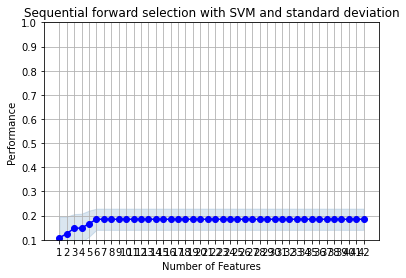

In [25]:
fig_sfs = plot_sfs(sfs.get_metric_dict(), kind='std_dev')#, figsize=(10, 6))
plt.ylim([0.1, 1])
plt.title('Sequential forward selection with SVM and standard deviation')
plt.grid()
plt.show()

## SFS results



```
# This is formatted as code
```

### SFS with XGboost

In [26]:
#Create a dataframe for the SFS results 
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()

In [27]:
# displays full row dataframe information
pd.set_option('display.max_colwidth', None)

In [28]:
df_SFS_results

,feature_idx,cv_scores,avg_score,feature_names
1,"(389,)","[0.19047619047619044, 0.0, 0.19047619047619044, 0.0, 0.15789473684210528]",0.107769,"(ETV6,)"
2,"(313, 389)","[0.1818181818181818, 0.09756097560975609, 0.19047619047619044, 0.0, 0.15789473684210528]",0.12555,"(MAP3K1, ETV6)"
3,"(313, 324, 389)","[0.18604651162790695, 0.09999999999999999, 0.19047619047619044, 0.05555555555555556, 0.20512820512820512]",0.147441,"(MAP3K1, PRDM1, ETV6)"
4,"(109, 313, 324, 389)","[0.18604651162790695, 0.10256410256410256, 0.19512195121951217, 0.05555555555555556, 0.20512820512820512]",0.148883,"(MAP1K4, MAP3K1, PRDM1, ETV6)"
5,"(109, 313, 324, 326, 389)","[0.1818181818181818, 0.10256410256410256, 0.23809523809523808, 0.10526315789473684, 0.20512820512820512]",0.166574,"(MAP1K4, MAP3K1, PRDM1, CCND3, ETV6)"
6,"(7, 109, 313, 324, 326, 389)","[0.1818181818181818, 0.19512195121951217, 0.23809523809523808, 0.10526315789473684, 0.20512820512820512]",0.185085,"(AKT1, MAP1K4, MAP3K1, PRDM1, CCND3, ETV6)"
7,"(1, 7, 109, 313, 324, 326, 389)","[0.1818181818181818, 0.19512195121951217, 0.23809523809523808, 0.10526315789473684, 0.20512820512820512]",0.185085,"(MDC1, AKT1, MAP1K4, MAP3K1, PRDM1, CCND3, ETV6)"
8,"(1, 2, 7, 109, 313, 324, 326, 389)","[0.1818181818181818, 0.19512195121951217, 0.23809523809523808, 0.10526315789473684, 0.20512820512820512]",0.185085,"(MDC1, ARAF, AKT1, MAP1K4, MAP3K1, PRDM1, CCND3, ETV6)"
9,"(1, 2, 3, 7, 109, 313, 324, 326, 389)","[0.1818181818181818, 0.19512195121951217, 0.23809523809523808, 0.10526315789473684, 0.20512820512820512]",0.185085,"(MDC1, ARAF, PREX1, AKT1, MAP1K4, MAP3K1, PRDM1, CCND3, ETV6)"
10,"(1, 2, 3, 5, 7, 109, 313, 324, 326, 389)","[0.1818181818181818, 0.19512195121951217, 0.23809523809523808, 0.10526315789473684, 0.20512820512820512]",0.185085,"(MDC1, ARAF, PREX1, PPP4R1, AKT1, MAP1K4, MAP3K1, PRDM1, CCND3, ETV6)"


6 = (AKT1, MAP1K4, MAP3K1, PRDM1, CCND3, ETV6)
AKT1, MAP1K4, MAP3K1, PRDM1, CCND3, ETV6)

---



In [ ]:
#sfs.subsets_[7]

In [29]:
sfs_feature_names_list = ['AKT1', 'MAP1K4', 'MAP3K1', 'PRDM1', 'CCND3', 'ETV6']

In [30]:
len(sfs_feature_names_list)

6

## Selecting the reduced columns

### Reduced columns for SFS with XgBoost

In [31]:
# feature_names = list(sfs.subsets_[number_of_clusters]['feature_names'])
feature_names = sfs_feature_names_list

In [32]:
X_selected = X_scaled[feature_names]

In [33]:
X_selected.head()

,AKT1,MAP1K4,MAP3K1,PRDM1,CCND3,ETV6
0,-0.08904,-0.142589,-0.068861,-0.153681,-0.064906,-0.097616
1,-0.08904,-0.142589,-0.068861,-0.153681,-0.064906,-0.097616
2,-0.08904,-0.142589,-0.068861,-0.153681,-0.064906,-0.097616
3,-0.08904,-0.142589,-0.068861,-0.153681,-0.064906,-0.097616
4,-0.08904,-0.142589,-0.068861,-0.153681,-0.064906,-0.097616


In [34]:
len(X_selected)

1907

# Running the models

## GridSearchCV with XGBoost

https://xgboost.readthedocs.io/en/latest/parameter.html

https://www.kaggle.com/phunter/xgboost-with-gridsearchcv

In [35]:
xgbc = xgb.XGBClassifier(use_label_encoder=False)

params_xgbc = {'objective': ['binary:logistic', 'binary:logitraw', 'binary:hinge'],
              'random_state': [SEED],
              'colsample_bytree': [0.001, 0.01, 0.05, 0.1, 0.5, 1],
              'learning_rate': [0.01, 0.05, 0.1, 0.5],
              'max_depth': [2, 4, 6],
              'alpha': [2, 4, 6, 8, 10]}

In [36]:
gs_xgbc = GridSearchCV(xgbc, 
                      param_grid = params_xgbc,  
                      scoring = ['roc_auc', 'f1', 'accuracy'],
                      refit = 'f1',
                      verbose = 3,
                      cv = 5)

In [37]:
start_gs_xgbc = time.clock()

gs_xgbc.fit(X_selected, y)

end_gs_xgbc = time.clock()

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
[CV] alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42 
[CV]  alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42, accuracy=0.908, f1=0.000, roc_auc=0.548, total=   0.0s
[CV] alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42 
[CV]  alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42, accuracy=0.906, f1=0.000, roc_auc=0.563, total=   0.0s
[CV] alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42 
[CV]  alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, objective=binary:logistic, random_state=42, accuracy=0.908, f1=0.000, roc_auc=0.561, total=   0.0s
[CV] alpha=2, colsample_bytree=0.001, learning_rate=0.01, max_depth=2, object

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV] alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42 
[CV]  alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42, accuracy=0.908, f1=0.000, roc_auc=0.548, total=   0.0s
[CV] alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42 
[CV]  alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42, accuracy=0.906, f1=0.000, roc_auc=0.571, total=   0.0s
[CV] alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42 
[CV]  alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_state=42, accuracy=0.908, f1=0.000, roc_auc=0.561, total=   0.0s
[CV] alpha=6, colsample_bytree=0.5, learning_rate=0.01, max_depth=4, objective=binary:logitraw, random_

[Parallel(n_jobs=1)]: Done 5400 out of 5400 | elapsed:  3.2min finished


In [38]:
calculate_elapsed_time(start_gs_xgbc, end_gs_xgbc)

This process took 3.20 minutes


In [39]:
xgbc_gs = gs_xgbc.best_estimator_

In [40]:
xgbc_gs

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [41]:
y_pred_xgbc = xgbc_gs.predict(X_selected)

### Confusion matrix and classification report

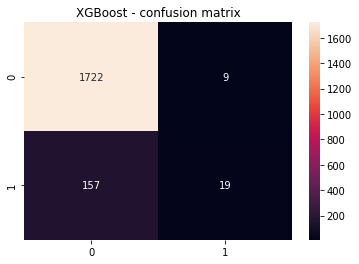

In [42]:
cm_xgbc = confusion_matrix(y, y_pred_xgbc)

sns.heatmap(cm_xgbc, annot=True, fmt='d').set_title('XGBoost - confusion matrix');

In [43]:
print('XGBoost - classification report\n\n', classification_report(y, y_pred_xgbc))

XGBoost - classification report

               precision    recall  f1-score   support

          -1       0.92      0.99      0.95      1731
           1       0.68      0.11      0.19       176

    accuracy                           0.91      1907
   macro avg       0.80      0.55      0.57      1907
weighted avg       0.89      0.91      0.88      1907



In [ ]:
xgbc_gs.fit(X_selected, y)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [ ]:
xgbc_gs.score(X_selected, y)

0.912952281069743

In [ ]:
xgbc_gs.score(X_test_selected, y_test)

0.9056603773584906

In [ ]:
pickle.dump(xgbc_gs, open('xgb_model.pkl', 'wb'))